In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator
from qiskit.circuit.library.standard_gates import TdgGate, SdgGate
from fractions import Fraction
from math import gcd

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()
import numpy as np
backend = AerSimulator()

# Verificar intercambio de compuertas

In [49]:
# Construcción de casos de prueba

def input_to_circuit(input_state, qc):
    for idx, item in enumerate(input_state):
        if item=='1':
            qc.x(len(input_state)-idx-1)

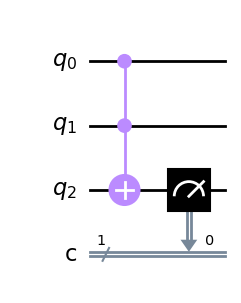

In [50]:
# Compuerta toffoli
def toffoli(qc):
    qc.ccx(0,1,2)

# Circuito para entrada 0
qc = QuantumCircuit(3, 1)

input_to_circuit('000', qc)

toffoli(qc)

qc.measure(2,0)

qc.draw('mpl')

In [86]:
def run_circuit(qc, shots=1000):
    results = backend.run(qc, shots=shots, memory=True).result()
    counts = results.get_counts()
    
    return (results, counts)

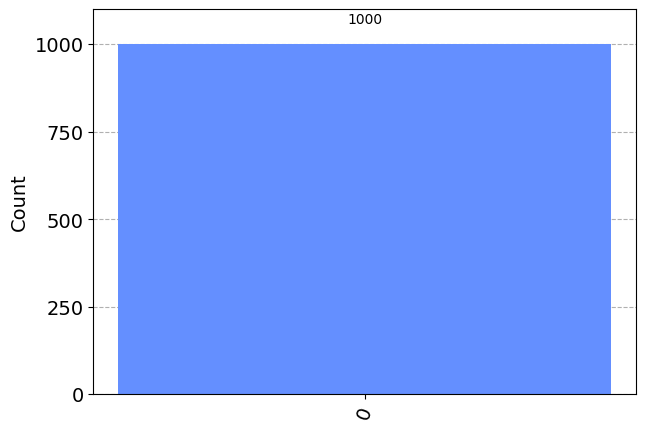

In [52]:
result,counts = run_circuit(qc)
plot_histogram(counts)

In [55]:
possible_states = ['000', '001', '010', '011', '100', '101', '110', '111']

In [57]:
for state in possible_states:
    # Circuito para entrada 0
    qc = QuantumCircuit(3, 1)

    input_to_circuit(state, qc)

    toffoli(qc)

    qc.measure(2,0)

    result,counts = run_circuit(qc)
    
    print('Estado ', state)
    print(counts)

Estado  000
{'0': 1000}
Estado  001
{'0': 1000}
Estado  010
{'0': 1000}
Estado  011
{'1': 1000}
Estado  100
{'1': 1000}
Estado  101
{'1': 1000}
Estado  110
{'1': 1000}
Estado  111
{'0': 1000}


In [58]:
# Compuerta Margolus como Toffoli

def Margolus(qc):
    qc.ry(np.pi/4, 2)
    qc.cx(1,2)
    qc.ry(np.pi/4, 2)
    qc.cx(0,2)
    qc.ry(-np.pi/4, 2)
    qc.cx(1,2)
    qc.ry(-np.pi/4, 2)


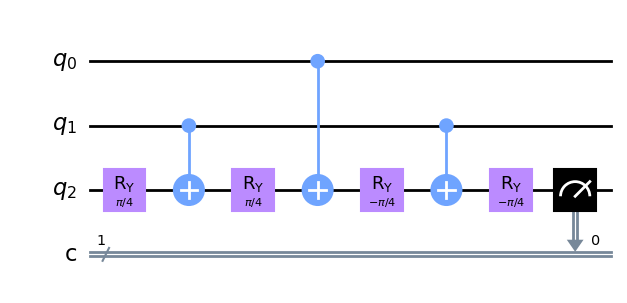

In [59]:
qc = QuantumCircuit(3, 1)

input_to_circuit('000', qc)

Margolus(qc)

qc.measure(2,0)

qc.draw('mpl')

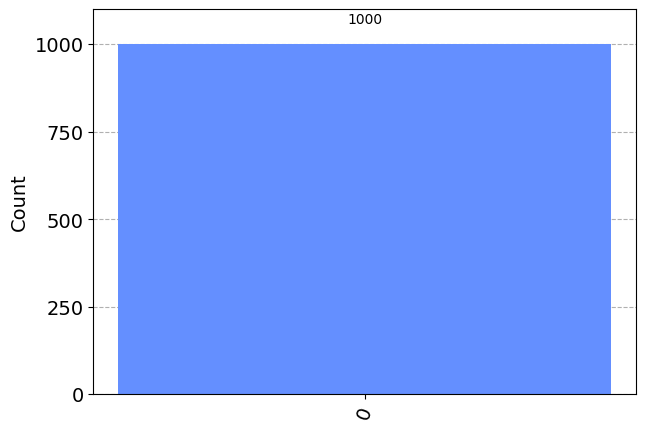

In [60]:
result,counts = run_circuit(qc)
plot_histogram(counts)

In [61]:
for state in possible_states:
    # Circuito para entrada 0
    qc = QuantumCircuit(3, 1)

    input_to_circuit(state, qc)

    Margolus(qc)

    qc.measure(2,0)

    result,counts = run_circuit(qc)
    
    print('Estado ', state)
    print(counts)

Estado  000
{'0': 1000}
Estado  001
{'0': 1000}
Estado  010
{'0': 1000}
Estado  011
{'1': 1000}
Estado  100
{'1': 1000}
Estado  101
{'1': 1000}
Estado  110
{'1': 1000}
Estado  111
{'0': 1000}


# Implementación circuitos

In [16]:
CTdg = TdgGate().control(1)
CSdg = SdgGate().control(1)

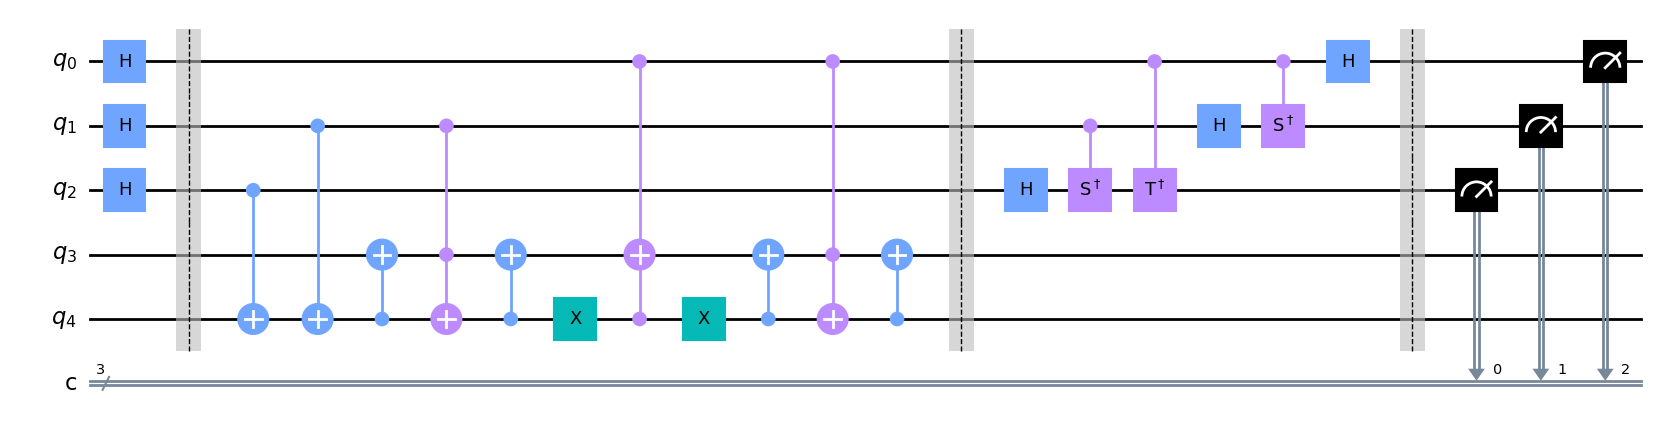

In [82]:
qc = QuantumCircuit(5, 3)

for i in range(3):
    qc.h(i)

qc.barrier()
#Implementación modulo

qc.cx(2,4)

qc.cx(1,4)
qc.cx(4,3)
qc.ccx(1,3,4)
qc.cx(4,3)

qc.x(4)
qc.ccx(0,4,3)
qc.x(4)
qc.cx(4,3)
qc.ccx(0,3,4)
qc.cx(4,3)

# Definición QFT inversa
qc.barrier()
qc.h(2)
qc.append(CSdg, [1, 2])
qc.append(CTdg, [0, 2])
qc.h(1)
qc.append(CSdg, [0, 1])
qc.h(0)

qc.barrier()
qc.measure([2,1,0],[0,1,2])
    
qc.draw('mpl')

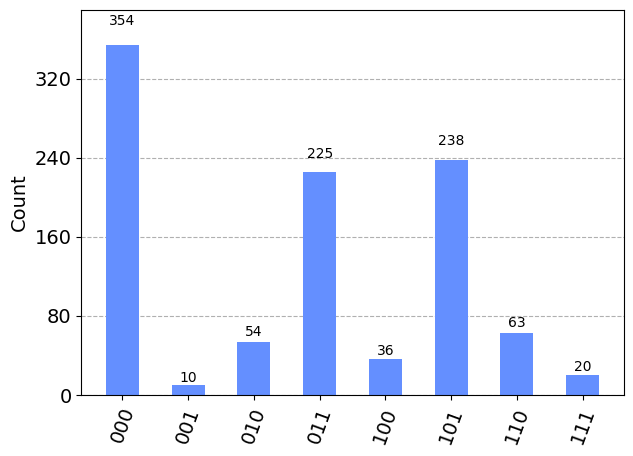

In [89]:
t_qc = transpile(qc, backend)
results = backend.run(t_qc, shots=1000, memory=True).result()
counts = results.get_counts()
    
plot_histogram(counts)

In [110]:
results = backend.run(t_qc, shots=1, memory=True).result()
readings = results.get_memory()
print("Register Reading: " + readings[0])
phase = int(readings[0],2)/(2**3)
print(f"Corresponding Phase: {phase}")

Register Reading: 010
Corresponding Phase: 0.25


In [111]:
fraction = Fraction(phase).limit_denominator(21)
fraction

Fraction(1, 4)

In [112]:
s, r = fraction.numerator, fraction.denominator
print(r)

4


In [113]:
a=4
N=21

In [114]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[3, 1]


In [18]:
def get_circuit_phase(t_qc):
    results = backend.run(t_qc, shots=1, memory=True).result()
    readings = results.get_memory()
    print(f"Reading: {readings[0]}")
    phase = int(readings[0],2)/(2**3)
    return phase

In [17]:
def find_factor(qc,a,N):
    t_qc = transpile(qc, backend)
    ATTEMPT = 0
    FACTOR_FOUND = False
    while not FACTOR_FOUND:
        ATTEMPT += 1
        print(f"\nATTEMPT {ATTEMPT}:")
        phase = get_circuit_phase(t_qc) # Phase = s/r
        frac = Fraction(phase).limit_denominator(N)
        r = frac.denominator
        print(f"Result: r = {r}")
        if phase != 0:
            # Guesses for factors are gcd(x^{r/2} ±1 , 15)
            print(f"Testing for factors: {a**(r//2)-1} and {a**(r//2)+1}")
            guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
            print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
            for guess in guesses:
                if guess not in [1,N] and (N % guess) == 0:
                    # Guess is a factor!
                    print(f"*** Non-trivial factor found: {guess} ***")
                    FACTOR_FOUND = True

In [124]:
find_factor(qc,a,N)


ATTEMPT 1:
Result: r = 8
Testing for factors: 255 and 257
Guessed Factors: 3 and 1
*** Non-trivial factor found: 3 ***


In [126]:
# Repetimos el procedimiento para Margolus

def margolus_parametric(c1,c2,r1):
    qc.ry(np.pi/4, r1)
    qc.cx(c2,r1)
    qc.ry(np.pi/4, r1)
    qc.cx(c1,r1)
    qc.ry(-np.pi/4, r1)
    qc.cx(c2,r1)
    qc.ry(-np.pi/4, r1)

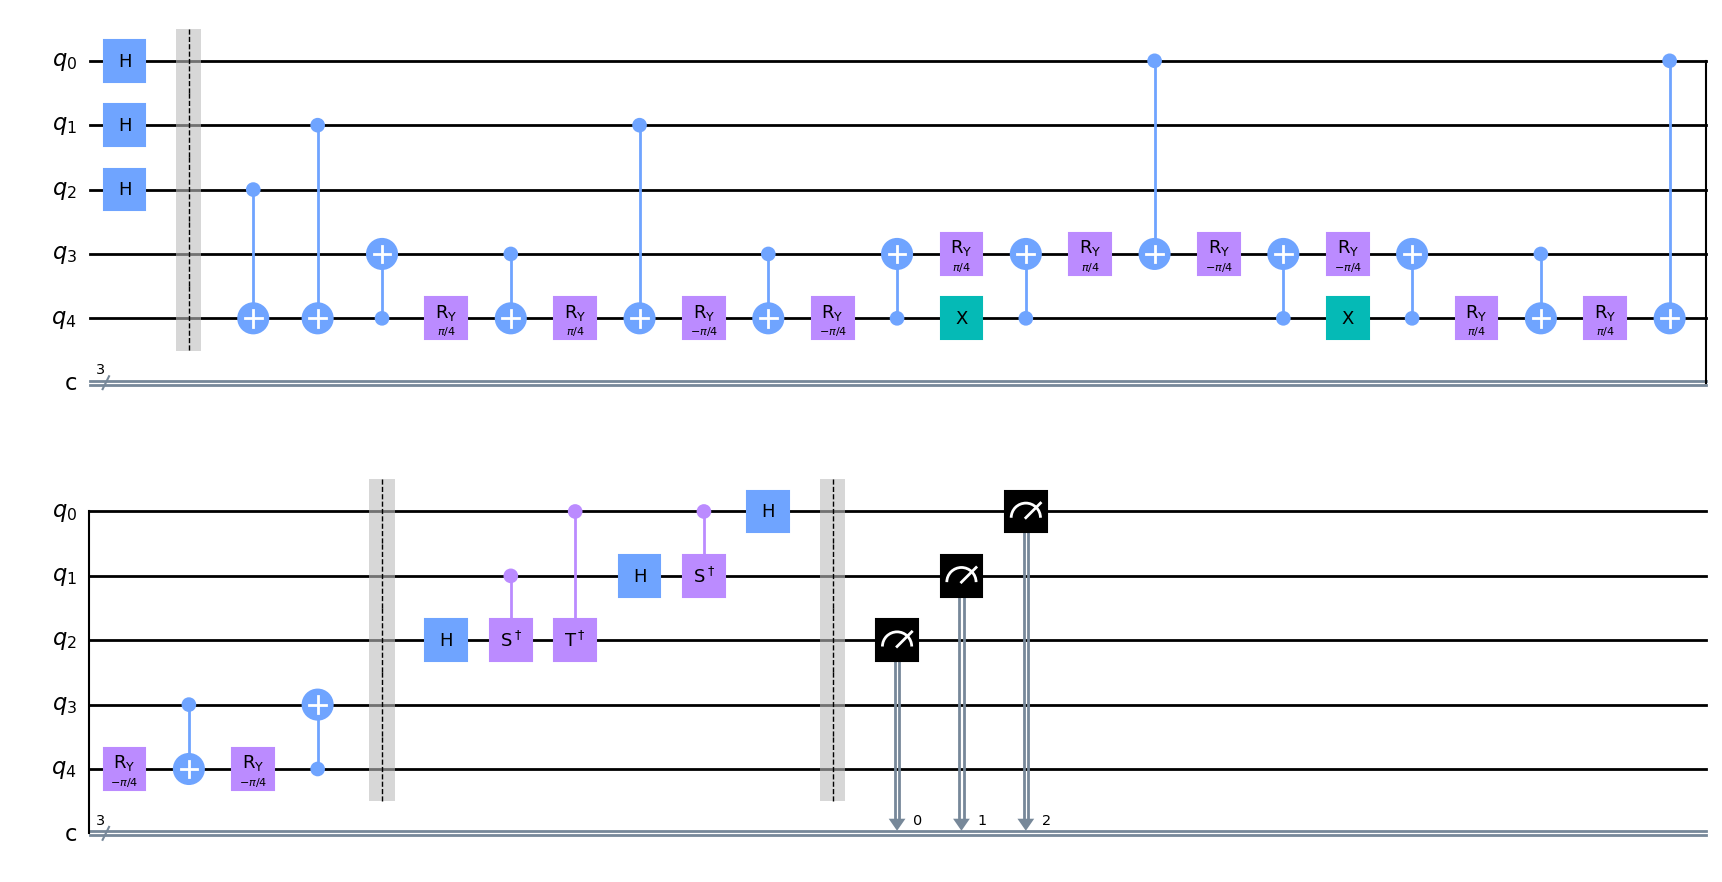

In [127]:
qc = QuantumCircuit(5, 3)

for i in range(3):
    qc.h(i)

qc.barrier()
#Implementación modulo

qc.cx(2,4)

qc.cx(1,4)
qc.cx(4,3)
margolus_parametric(1,3,4)
qc.cx(4,3)

qc.x(4)
margolus_parametric(0,4,3)
qc.x(4)
qc.cx(4,3)
margolus_parametric(0,3,4)
qc.cx(4,3)

# Definición QFT inversa
qc.barrier()
qc.h(2)
qc.append(CSdg, [1, 2])
qc.append(CTdg, [0, 2])
qc.h(1)
qc.append(CSdg, [0, 1])
qc.h(0)

qc.barrier()
qc.measure([2,1,0],[0,1,2])
    
qc.draw('mpl')

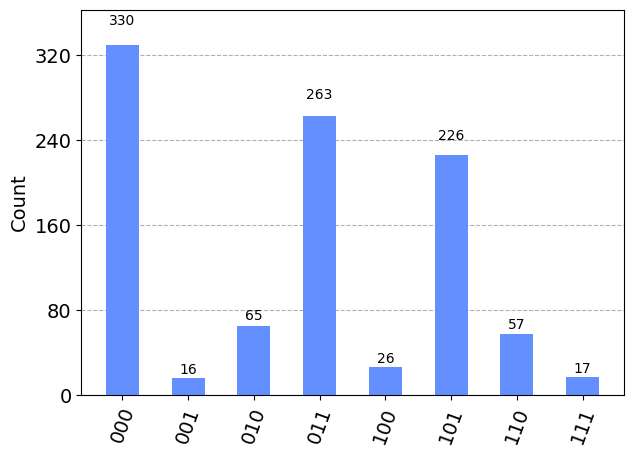

In [128]:
t_qc = transpile(qc, backend)
results = backend.run(t_qc, shots=1000, memory=True).result()
counts = results.get_counts()
    
plot_histogram(counts)

In [129]:
find_factor(qc,a,N)


ATTEMPT 1:
Result: r = 8
Testing for factors: 255 and 257
Guessed Factors: 3 and 1
*** Non-trivial factor found: 3 ***


# Dificultades para otras a

In [2]:
import matplotlib.pyplot as plt

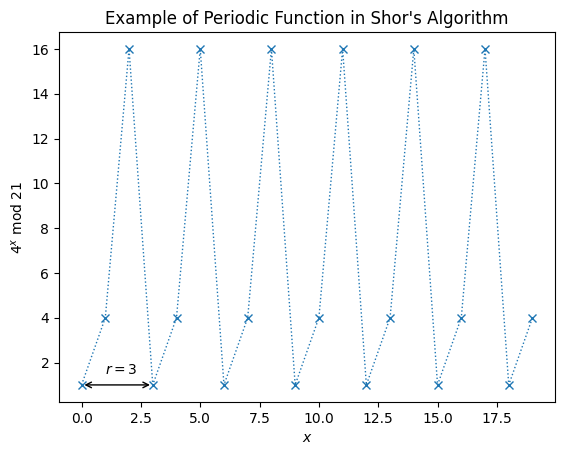

In [26]:
# Encontrar el periodo para un a
N = 21
a = 4

# Calculate the plotting data
xvals = np.arange(20)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

In [146]:
np.log(21)/np.log(2)

4.392317422778761

In [13]:
yvals

[1, 13, 1, 13, 1, 13, 1, 13, 1, 13, 1, 13, 1, 13, 1, 13, 1, 13, 10, 9]

In [14]:
np.log(yvals)/np.log(a)

array([0.        , 1.        , 0.        , 1.        , 0.        ,
       1.        , 0.        , 1.        , 0.        , 1.        ,
       0.        , 1.        , 0.        , 1.        , 0.        ,
       1.        , 0.        , 1.        , 0.89771172, 0.85663468])

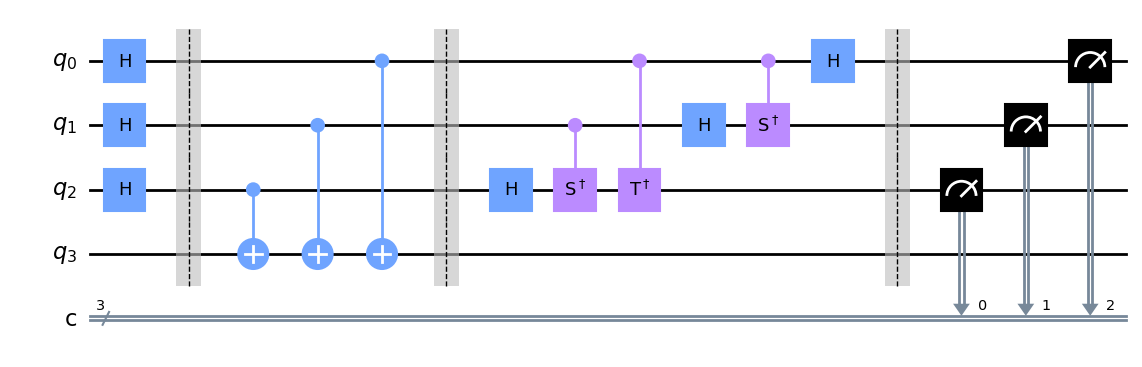

In [19]:
qc = QuantumCircuit(4, 3)

for i in range(3):
    qc.h(i)

qc.barrier()
#Implementación modulo

qc.cx(2,3)

qc.cx(1,3)

qc.cx(0,3)

# Definición QFT inversa
qc.barrier()
qc.h(2)
qc.append(CSdg, [1, 2])
qc.append(CTdg, [0, 2])
qc.h(1)
qc.append(CSdg, [0, 1])
qc.h(0)

qc.barrier()
qc.measure([2,1,0],[0,1,2])
    
qc.draw('mpl')

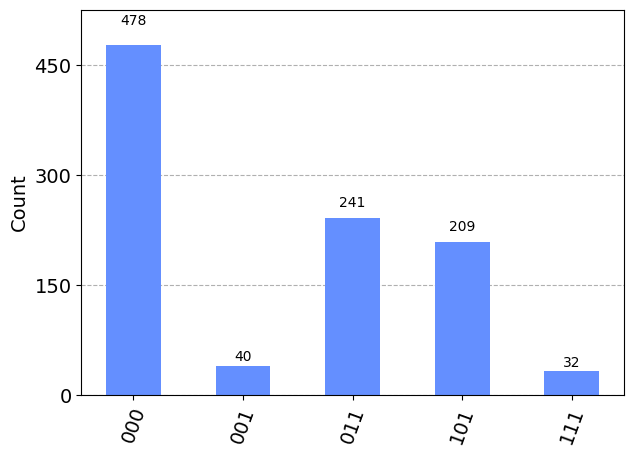

In [20]:
t_qc = transpile(qc, backend)
results = backend.run(t_qc, shots=1000, memory=True).result()
counts = results.get_counts()
    
plot_histogram(counts)

In [22]:
results = backend.run(t_qc, shots=1, memory=True).result()
readings = results.get_memory()
print("Register Reading: " + readings[0])
phase = int(readings[0],2)/(2**3)
print(f"Corresponding Phase: {phase}")

Register Reading: 101
Corresponding Phase: 0.625


In [23]:
fraction = Fraction(phase).limit_denominator(21)
fraction

Fraction(5, 8)

In [24]:
s, r = fraction.numerator, fraction.denominator
print(r)

8


In [25]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[21, 1]


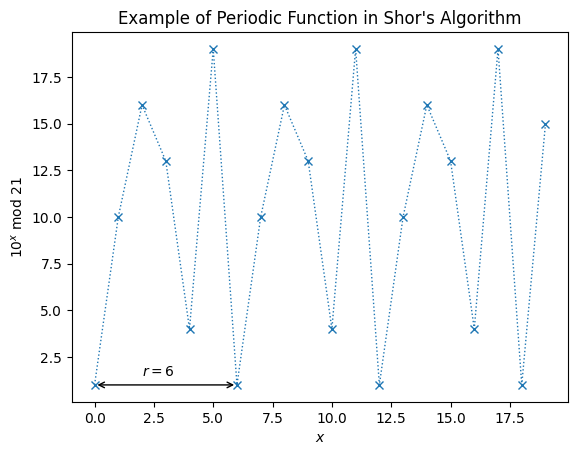

In [166]:
# Encontrar el periodo para un a
N = 21
a = 10

# Calculate the plotting data
xvals = np.arange(20)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

In [168]:
yvals

[1, 10, 16, 13, 4, 19, 1, 10, 16, 13, 4, 19, 1, 10, 16, 13, 4, 19, 1, 15]

In [167]:
np.log(yvals)/np.log(a)

array([0.        , 1.        , 1.20411998, 1.11394335, 0.60205999,
       1.2787536 , 0.        , 1.        , 1.20411998, 1.11394335,
       0.60205999, 1.2787536 , 0.        , 1.        , 1.20411998,
       1.11394335, 0.60205999, 1.2787536 , 0.        , 1.17609126])